Installing required resources
----------------

In [ ]:
# Using pip3 to install for Python 3.x; remove the quiet flag (-q) if you want to see the output

# Standard downloads
!pip3 -q install numpy scipy pandas matplotlib pymatbridge seaborn --user

# The spinkyDemo package, which provide a set of utilitary functions useful to avoid clutering 
# this example with a lot of code.
!pip3 -q install git+https://github.com/christian-oreilly/spinkyDemo.git --user --upgrade

# Cloning the SPINKY Matlab Git repository
import os
if not os.path.isdir("SPINKY"):
    !git clone https://github.com/TarekLaj/SPINKY.git
        
# Downloading an example of EEG + scoring from the DREAMS database        
# for the spindle example...
!wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/excerpt1.txt"
!wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/Visual_scoring1_excerpt1.txt"   

# for the K-complex example
!wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseKcomplexes/excerpt2.txt"
!wget "http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseKcomplexes/Visual_scoring1_excerpt2.txt"

Importing required functions and packages
--------------

In [42]:
# Standard imports
import numpy as np
from scipy.io import savemat 
import sys
import os
from glob import glob
import pandas as pd
import seaborn as sb
import matplotlib.pylab as plt

# Imports from spinkyDemo
from spinkyDemo import training_process, test_process, readDetectorOutput
from spinkyDemo import sensitivity, specificity, PPV, MCC, cohenk, F1

Defining some constants...
---------------------------

In [52]:
# Constants
spinkyPath   = os.path.join(os.getcwd(), 'SPINKY')
pageDuration = 30.0        # Page length, in seconds
nbTrainPage  = 20          # Number of pages to use for the training  
mode         = 'spindles'  # change to 'kcomplex' for K-complexes

if mode == "spindles":
    eegFileName     = "excerpt1.txt"
    scoringFileName = "Visual_scoring1_excerpt1.txt"
    subjectName     = "exerpt1"
    fs              = 100.0       # Sampling frequency, in Hz
    outputFileName  = "score_auto_spindles_" + subjectName + ".txt"
    from spinkyDemo import sp_thresholds_ranges as thresholds_ranges 
    
elif mode == "kcomplex":
    eegFileName     = "excerpt2.txt"
    scoringFileName = "Visual_scoring1_excerpt2.txt"
    subjectName     = "exerpt2"
    fs              = 200.0       # Sampling frequency, in Hz   
    outputFileName  = "score_auto_Kcomplex_" + subjectName + ".txt"    
    from spinkyDemo import kp_thresholds_ranges as thresholds_ranges 
    
else:
    raise ValueError

Preparing the training and testing signals
---------------------

In [53]:
eegSig          = pd.read_csv(eegFileName, names=["signal"], skiprows=[0])["signal"].values
scoring         = pd.read_csv(scoringFileName, sep="\t", names=["start", "duration"], skiprows=[0])
scoringStart    = scoring["start"].values
scoringDuration = scoring["duration"].values
samplePerPage   = int(pageDuration*fs)
numberOfPages   = int(len(eegSig)/samplePerPage)

# Getting signals based on two mutually exclusive set of pages for training and testing
np.random.seed(42)
pageIds      = range(numberOfPages)
trainPageIds = np.random.choice(pageIds, nbTrainPage, replace=False)
trainSig     = eegSig[np.concatenate([np.arange(samplePerPage)+i*samplePerPage 
                                      for i in pageIds if i in trainPageIds])]
testSig      = eegSig[np.concatenate([np.arange(samplePerPage)+i*samplePerPage 
                                      for i in pageIds if not i in trainPageIds])]

# Calculating the number of spindles scored in the training pages
def eventInPage(eventStart, pageId):
    pageStart = pageId*pageDuration
    pageEnd   = pageStart + pageDuration    
    return (eventStart >= pageStart)*(eventStart < pageEnd)

nbEvents = [sum(eventInPage(scoringStart, pageId)) for pageId in trainPageIds]

Starting Matlab and adding necessary paths to Matlab environement variable
--------

In [54]:
from pymatbridge import Matlab
mlab = Matlab(maxtime=60) #Matlab(matlab='C:/Program Files/MATLAB/R2015a/bin/matlab.exe')
mlab.start()

matlabCode = \
"rootPath = '" + spinkyPath + "/'; \n" + """
addpath(rootPath) 
addpath([rootPath 'functions'])
addpath([rootPath 'functions/tqwt_matlab_toolbox/tqwt_matlab_toolbox'])
"""
result = mlab.run_code(matlabCode)

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-279fa452-b995-4650-8b52-9c6e737683ad
Send 'exit' command to kill the server
......MATLAB started and connected!


Example of threshold estimation (for spindles detection)
---------------

In [55]:
threshold = thresholds_ranges(mlab, trainSig, samplePerPage, fs)[0]

In [56]:
threshold = training_process(mlab, trainSig, fs, samplePerPage, mode, threshold, nbEvents)
print("Threshold:", threshold) 

Threshold: 18


Example of spindle detection
---------------

In [57]:
# This call create a file named score_auto_YYYYYY_XXXXXX.txt where XXXXXX is the value of subjectName
# and YYYYYY takes eithers spindles or Kcomplex depending on the value of mode.
test_process(mlab, testSig, fs, samplePerPage, subjectName, threshold, mode)

array([[ 0.,  0.,  1.,  2.,  1.,  2.,  4.,  1.,  1.,  2.,  2.,  0.,  2.,
         3.,  3.,  4.,  3.,  2.,  4.,  4.,  5.,  4.,  5.,  4.,  4.,  4.,
         3.,  4.,  4.,  4.,  2.,  3.,  3.,  5.,  3.,  3.,  4.,  3.,  3.,
         2.]])

Closing Matlab
-----------------------

In [58]:
mlab.quit()

{'content': {'stdout': 'Too many output arguments.'},
 'result': '',
 'success': False}

Example of performance assessment
---------------

In [59]:
def makeIndexSignal(events, epoch_length, fs):    
    index = np.zeros((int(epoch_length*fs), 1))
    for s, e in events:
        index[int(np.round(s*fs)):int(np.round(e*fs))] = 1
    return index
    
    
def compute2classComp(indGold, indTest):    
    
    TP = np.logical_and(indGold, indTest)
    TN = np.logical_and(np.logical_not(indGold), np.logical_not(indTest)) 
    FP = np.logical_and(np.logical_not(indGold), indTest)
    FN = np.logical_and(indGold, np.logical_not(indTest))

    return TP, TN, FP, FN


def prinResults(TP, TN, FP, FN):
    res = ( sensitivity(TP, TN, FP, FN), 
            specificity(TP, TN, FP, FN),
            PPV(TP, TN, FP, FN), 
            MCC(TP, TN, FP, FN),
            cohenk(TP, TN, FP, FN), 
            F1(TP, TN, FP, FN))
    print(("sensitivity=%f, specificity=%f, PPV=%f,  MCC=%f, CohenK=%f, F1=%f" % res))     
    return res

detectedEvents = readDetectorOutput(outputFileName, mode)

TP = []
TN = [] 
FP = []
FN = []

indGoldAll = []
indTestAll = []

detectedPageNo = 0
for pageId in pageIds:
    if pageId in trainPageIds:
        continue
        
    detectedPageNo += 1
        
    pageStart = pageId*pageDuration
    pageEnd   = pageStart + pageDuration  
    
    eventPage = []
    if mode == "spindles":
        eventPage = [(eStart - pageStart, eStart + eDuration - pageStart) 
                        for eStart, eDuration in zip(scoringStart, scoringDuration) 
                                       if eventInPage(eStart, pageId)]

        detectEventPage = [(event["start"], event["end"]) for index, event 
                             in detectedEvents[detectedEvents["page"] == detectedPageNo].iterrows()]            
        
    elif mode == "kcomplex":
        for eStart, eDuration in zip(scoringStart, scoringDuration):
            if eventInPage(eStart, pageId):
                sig = eegSig[np.arange(int(eStart*fs), int((eStart+eDuration)*fs))]                
                pic = eStart - pageStart + float(np.argmin(sig))/fs
                eventPage.append((pic-0.1, pic+1.3))    

        detectEventPage = [(event["time"]-0.1, event["time"]+1.3) for index, event 
                             in detectedEvents[detectedEvents["page"] == detectedPageNo].iterrows()]                
                      
    indGold = makeIndexSignal(eventPage, pageDuration, fs)
    indTest = makeIndexSignal(detectEventPage, pageDuration, fs)

    indGoldAll.extend(indGold)
    indTestAll.extend(indTest)
    
    TPtmp, TNtmp, FPtmp, FNtmp = compute2classComp(indGold, indTest)
    TP.extend(TPtmp)
    TN.extend(TNtmp)
    FP.extend(FPtmp)
    FN.extend(FNtmp)

print("")
prinResults(np.sum(TP, dtype=np.int64), 
            np.sum(TN, dtype=np.int64), 
            np.sum(FP, dtype=np.int64), 
            np.sum(FN, dtype=np.int64))
print("")


sensitivity=0.705687, specificity=0.551599, PPV=0.046693,  MCC=0.088379, CohenK=0.032830, F1=0.087591



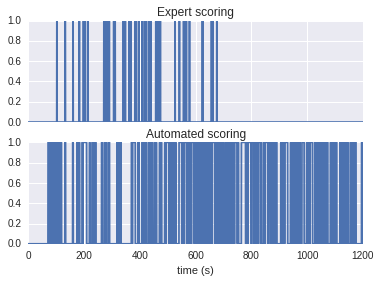

In [60]:
%matplotlib inline

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(np.arange(len(indGoldAll))/fs, indGoldAll)
axes[0].set_title("Expert scoring")

axes[1].plot(np.arange(len(indTestAll))/fs, indTestAll)
axes[1].set_title("Automated scoring")
axes[1].set_xlabel("time (s)")
